# Bacterial Ensemble Language Model

This notebook trains a language model on the ensemble of bacterial genomes assembled in the [Bacterial Ensemble 0 Data Processing](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/Bacterial%20Ensemble/Bacterial%20Ensemble%200%20Data%20Processing.ipynb) notebook. The language model trained is based on the AWD-LSTM architecture. the genomic input information is split into 5-mers with a stride of 2 bases between each 5-mer. The model is trained to take an input sequence of 5-mers and predict the next 5-mer. This allows us to train a model that learns the structure of genomic information in a totally unsupervised way.

The base of the language model (token embedding + LSTM layers) will then be used to initialize a classification model.

For more detail on how genomic data is processed and how these language models are trained, see the following notebooks:

[E. coli 1 Naive Model](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%201%20Naive%20Model.ipynb)

[E. coli 2 Genomic Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%202%20Genomic%20Pretraining.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

# sets device for model and PyTorch tensors
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7" # "-1" if want to run on a CPU, otherwise define the GPU number

In [3]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [4]:
sys.path.append("../../..")
from utils import *

In [5]:
path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/')

In [15]:
df = pd.read_csv(path/'bacterial_data.csv')

In [16]:
df.head()

,Sequence,Source
0,CATCGACGAGGGAACGCAGATTTTTCGTTAAAGCTCTGGCCCCTCG...,Corynebacterium striatum
1,TGGCTGGGTCTCGGCGATATAGAGGAAGTTGCCCTCACGCCCACGA...,Corynebacterium striatum
2,GTCGGTGCCGACGAAAGCGCGGGCAATCGTCATGGATTCATCAGCC...,Corynebacterium striatum
3,GAGTTTCTGGCTCAAGATTTCACGCACCGTGGCTTGATACACCATG...,Corynebacterium striatum
4,ACGCTGAGATTCTTTCCGAGCCCATTTTCTAGCCTGTCCCATTGGC...,Corynebacterium striatum


In [17]:
df = df[:100]

In [18]:
# 10% of the data used for validation
train_df, valid_df = split_data(df, 0.9)

In [19]:
train_df.shape, valid_df.shape

((91, 2), (9, 2))

In [20]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [21]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=800, tokenizer=tok, text_cols=0, label_cols=1)

In [22]:
# Model vocabulary - 1025 tokens. 1024 5-mer nucleotide combinations plus one padding token
len(data.vocab.itos)

1025

In [23]:
# Save model vocabulary - this will be important later
np.save(path/'bact_vocab.npy', data.vocab.itos)

In [24]:
voc = np.load(path/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [25]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=800, tokenizer=tok, vocab=model_vocab,
                              chunksize=80000, text_cols=0, label_cols=1)

In [26]:
len(data.vocab.itos), len(data.vocab.stoi)

(1025, 1025)

In [27]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [28]:
learn = get_model_LM(data, drop_mult, config)

In [29]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [30]:
learn.lr_find(num_it=4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


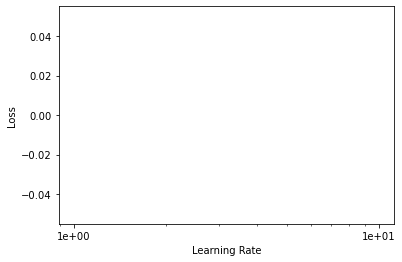

In [39]:
graph=learn.recorder.plot(return_fig=True)
graph.savefig('loss.png')

In [ ]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('b1', return_path=True)

In [ ]:
learn.fit_one_cycle(5, 5e-3, moms=(0.8,0.7))

In [ ]:
learn.save('b2', return_path=True)

In [ ]:
learn.save_encoder('b2_enc', return_path=True)